#**Практическое задание №1**

Установка необходимых пакетов:

In [1]:
!pip install -q tqdm
!pip install --upgrade --no-cache-dir gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


Монтирование Вашего Google Drive к текущему окружению:

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Константы, которые пригодятся в коде далее, и ссылки (gdrive идентификаторы) на предоставляемые наборы данных:

In [3]:
EVALUATE_ONLY = True
TEST_ON_LARGE_DATASET = True
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')
DATASETS_LINKS = {
    'train': '1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi',
    'train_small': '1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR',
    'train_tiny': '1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui',
    'test': '1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr',
    'my_test': '1jU1N5Ki9ikwdJMAaqy7xhVMz2ZNKzWj_',
    'my_train':'1e4GeqU0uIlbJ9_ENJ6mM13kUGwuasuvz',
    'test_small':'1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI',
    'test_tiny': '1viiB0s041CNsAK4itvX8PnYthJ-MDnQc'
}

Импорт необходимых зависимостей:

In [37]:
from pathlib import Path
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display
import sklearn
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
import gdown
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings(action='once')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


---
### Класс Dataset

Предназначен для работы с наборами данных, обеспечивает чтение изображений и соответствующих меток, а также формирование пакетов (батчей).

In [5]:
class Dataset:

    def __init__(self, name):
        self.name = name
        self.is_loaded = False
        url = f"https://drive.google.com/uc?export=download&confirm=pbef&id={DATASETS_LINKS[name]}"
        output = f'{name}.npz'
        gdown.download(url, output, quiet=False)
        print(f'Loading dataset {self.name} from npz.')
        np_obj = np.load(f'{name}.npz')
        self.images = np_obj['data']
        self.labels = np_obj['labels']
        self.n_files = self.images.shape[0]
        self.is_loaded = True
        print(f'Done. Dataset {name} consists of {self.n_files} images.')

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]

    def random_batch_with_labels(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Пример использвания класса Dataset
Загрузим обучающий набор данных, получим произвольное изображение с меткой. После чего визуализируем изображение, выведем метку. В будущем, этот кусок кода можно закомментировать или убрать.

---
### Класс Metrics

Реализует метрики точности, используемые для оценивания модели:
1. точность,
2. сбалансированную точность.

In [7]:
class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

---
### Класс Model

Класс, хранящий в себе всю информацию о модели.

Вам необходимо реализовать методы save, load для сохранения и заргрузки модели. Особенно актуально это будет во время тестирования на дополнительных наборах данных.

> *Пожалуйста, убедитесь, что сохранение и загрузка модели работает корректно. Для этого обучите модель, протестируйте, сохраните ее в файл, перезапустите среду выполнения, загрузите обученную модель из файла, вновь протестируйте ее на тестовой выборке и убедитесь в том, что получаемые метрики совпадают с полученными для тестовой выбрки ранее.*


Также, Вы можете реализовать дополнительные функции, такие как:
1. валидацию модели на части обучающей выборки;
2. использование кроссвалидации;
3. автоматическое сохранение модели при обучении;
4. загрузку модели с какой-то конкретной итерации обучения (если используется итеративное обучение);
5. вывод различных показателей в процессе обучения (например, значение функции потерь на каждой эпохе);
6. построение графиков, визуализирующих процесс обучения (например, график зависимости функции потерь от номера эпохи обучения);
7. автоматическое тестирование на тестовом наборе/наборах данных после каждой эпохи обучения (при использовании итеративного обучения);
8. автоматический выбор гиперпараметров модели во время обучения;
9. сохранение и визуализацию результатов тестирования;
10. Использование аугментации и других способов синтетического расширения набора данных (дополнительным плюсом будет обоснование необходимости и обоснование выбора конкретных типов аугментации)
11. и т.д.

Полный список опций и дополнений приведен в презентации с описанием задания.

При реализации дополнительных функций допускается добавление параметров в существующие методы и добавление новых методов в класс модели.

In [8]:
import torchvision
from torchvision import datasets, models, transforms
import torch
import torch.nn as nn
import torch.optim as optim

def create_model(model, num_freeze_layers, num_out_classes):
    model.fc = nn.Linear(512, num_out_classes)

    for i, layer in enumerate(model.children()):
        if i < num_freeze_layers:
            for param in layer.parameters():
                param.requires_grad = False

    return model

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen 

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
from torchvision.transforms import v2
#resnet_transforms = models.ResNet18_Weights.IMAGENET1K_V1.transforms()
resnet_transforms = v2.Compose([
        #transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
        #LBL1
        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomVerticalFlip(p=0.5),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [173]:
class DataLoader:
    #LBL2
    def __init__(self, dataset: Dataset, transforms):
        self.dataset = dataset
        self.transforms = transforms

    def train_split(self, batch_size=32, val_size=0.2):
        self.batch_size = batch_size
        self.train_size = int((1 - val_size) * self.dataset.n_files)
        self.index = np.arange(self.dataset.n_files, dtype=int)
        np.random.shuffle(self.index)
        self.b_given_train = 0
        self.b_given_val = 0

    def get_batch(self, val=False):
        if val:
            idx = self.index[self.train_size + self.b_given_train:
                             self.train_size + self.b_given_train + self.batch_size]
        else:
            idx = self.index[self.b_given_train : self.b_given_train + self.batch_size]

        X_batch = torch.empty(self.batch_size, 3, 224, 224)
        y_batch = torch.empty(self.batch_size)
        for i, data in enumerate(idx):
            img, lbl = self.dataset.image_with_label(data)
            img = self.transforms(torch.from_numpy(img).permute(2, 0, 1))

            X_batch[i] = img
            y_batch[i] = lbl

        if val:
            self.b_given_val += self.batch_size
            if self.b_given_val + self.batch_size > self.dataset.n_files:
                self.b_given_val = 0
        else:
            self.b_given_train += self.batch_size
            if self.b_given_train + self.batch_size > self.train_size:
                self.b_given_train = 0
        return (X_batch.type(torch.FloatTensor), y_batch.type(torch.LongTensor))

class Model:

    def __init__(self):
        self.model = create_model(models.resnet18(pretrained=True), 6, 9).to(device)

    def save(self, name: str):
        torch.save(self.model.state_dict(), f'/content/drive/MyDrive/{name}.npz')

    def load(self, name: str):
        name_to_id_dict = {
            'best': '1-WsnJ0mZD7xaqdQDSC9nyta7whwoJ4Ii'
        }
        output = f'{name}.npz'
        gdown.download(f'https://drive.google.com/uc?id={name_to_id_dict[name]}', output, quiet=False)
        self.model.load_state_dict(torch.load(output))
        self.model.to(device)
        self.model.eval()

    def train(self, dataset: Dataset):
        loss_fn = torch.nn.CrossEntropyLoss(weight=torch.Tensor([1., 1., 0.7, 1., 0.95, 0.7, 0.6, 0.5, 0.8]).to(device))

        learning_rate = 1e-4
        optimizer = torch.optim.Adamax(self.model.parameters(), lr=learning_rate)
        print(f'training started')

        n_epoch = 10

        dataloader = DataLoader(dataset, resnet_transforms)

        for epoch in range(n_epoch):
            print("Epoch:", epoch+1)

            self.model.train(True)

            dataloader.train_split()

            running_losses = []
            running_accuracies = []
            for i in range(dataloader.train_size // dataloader.batch_size):

                X_batch, y_batch = dataloader.get_batch()

                logits = self.model(X_batch.to(device))
                loss = loss_fn(logits, y_batch.to(device))

                running_losses.append(loss.cpu().item())

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                model_answers = torch.argmax(logits, dim=1)
                train_accuracy = torch.sum(y_batch == model_answers.cpu()) / len(y_batch)
                running_accuracies.append(train_accuracy)

                if (i+1) % 50 == 0:
                    #LBL4
                    print("Mean train loss and accuracy on last 50 iterations:",
                        np.mean(running_losses), np.mean(running_accuracies), end='\n')

            self.model.train(False)

            #LBL3
            losses = []

            num_correct = 0
            num_elements = 0

            for i in range((dataloader.dataset.n_files - dataloader.train_size) // dataloader.batch_size):

                X_batch, y_batch = dataloader.get_batch(val=True)
                num_elements += len(y_batch)


                with torch.no_grad():

                    logits = self.model(X_batch.to(device))

                    loss = loss_fn(logits, y_batch.to(device))
                    losses.append(loss.cpu().item())

                    y_pred = torch.argmax(logits, dim=1)

                    num_correct += torch.sum(y_pred.cpu() == y_batch)

            accuracy = num_correct / num_elements

            val_accuracy, val_loss = accuracy.numpy(), np.mean(losses)
            #LBL4
            print("Epoch {}/{}: val loss and accuracy:".format(epoch+1, n_epoch,),
                        val_loss, val_accuracy, end='\n')


        print(f'training done')

    def test_on_dataset(self, dataset: Dataset, limit=None):
        predictions = []
        n = dataset.n_files if not limit else int(dataset.n_files * limit)
        for img in tqdm(dataset.images_seq(n), total=n):
            predictions.append(self.test_on_image(img))
        return predictions

    def test_on_image(self, img: np.ndarray):
        resnet_transforms = v2.Compose([
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        prediction = self.model(resnet_transforms(torch.from_numpy(img).permute(2, 0, 1))[None, :, :, :].to(device))
        prediction = int(torch.argmax(prediction, dim=1).cpu()[0])
        return prediction


---
### Классификация изображений

Используя введенные выше классы можем перейти уже непосредственно к обучению модели классификации изображений. Пример общего пайплайна решения задачи приведен ниже. Вы можете его расширять и улучшать. В данном примере используются наборы данных 'train_small' и 'test_small'.

In [13]:
d_train = Dataset('my_train')
d_test = Dataset('my_test')

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1e4GeqU0uIlbJ9_ENJ6mM13kUGwuasuvz
To: /content/my_train.npz
100%|██████████| 2.10G/2.10G [00:21<00:00, 95.8MB/s]


Loading dataset my_train from npz.
Done. Dataset my_train consists of 18000 images.


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1jU1N5Ki9ikwdJMAaqy7xhVMz2ZNKzWj_
To: /content/my_test.npz
100%|██████████| 525M/525M [00:03<00:00, 148MB/s]


Loading dataset my_test from npz.
Done. Dataset my_test consists of 4500 images.


In [174]:
model = Model()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [175]:
model.load('best')

Downloading...
From (uriginal): https://drive.google.com/uc?id=1-WsnJ0mZD7xaqdQDSC9nyta7whwoJ4Ii
From (redirected): https://drive.google.com/uc?id=1-WsnJ0mZD7xaqdQDSC9nyta7whwoJ4Ii&confirm=t&uuid=2617f02e-3b07-4300-816b-ec7300801dfb
To: /content/best.npz
100%|██████████| 44.8M/44.8M [00:00<00:00, 72.9MB/s]


In [159]:
if  EVALUATE_ONLY:
    model.train(d_train)
    model.save('best')
else:
    #todo: your link goes here
    model.load('best')

training started
Epoch: 1
Mean train loss and accuracy on last 50 iterations: 0.0020009855398529907 1.0
Mean train loss and accuracy on last 50 iterations: 0.00222670191558791 0.9996875
Mean train loss and accuracy on last 50 iterations: 0.002053389640908184 0.9997917
Mean train loss and accuracy on last 50 iterations: 0.0020222388779347965 0.99953127
Mean train loss and accuracy on last 50 iterations: 0.002263896646509238 0.9995
Mean train loss and accuracy on last 50 iterations: 0.0025162721525399927 0.999375
Mean train loss and accuracy on last 50 iterations: 0.0029624514420512633 0.9992857
Mean train loss and accuracy on last 50 iterations: 0.002820705876657712 0.9992969
Mean train loss and accuracy on last 50 iterations: 0.0027880918003969175 0.99930555
Epoch 1/10: val loss and accuracy: 0.00020305935663600394 1.0
Epoch: 2
Mean train loss and accuracy on last 50 iterations: 0.002658515687835461 0.99875
Mean train loss and accuracy on last 50 iterations: 0.0019475036337917118 0.999

Пример тестирования модели на части набора данных:

In [17]:
# evaluating model on 10% of test dataset
pred_1 = model.test_on_dataset(d_test, limit=0.1)
Metrics.print_all(d_test.labels[:len(pred_1)], pred_1, '10% of test')

  0%|          | 0/450 [00:00<?, ?it/s]

metrics for 10% of test:
	 accuracy 1.0000:
	 balanced accuracy 1.0000:


Пример тестирования модели на полном наборе данных:

In [66]:
#LBL5
def c_matrix(gt: List[int], pred: List[int]):
    plt.figure(figsize=(10,8))
    matrix = sklearn.metrics.confusion_matrix(gt, pred)
    sns.heatmap(matrix, xticklabels=np.arange(9), yticklabels=np.arange(9), center=0, annot=True)

    plt.title('Confusion Matrix', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=90)
    plt.show()

  0%|          | 0/4500 [00:00<?, ?it/s]

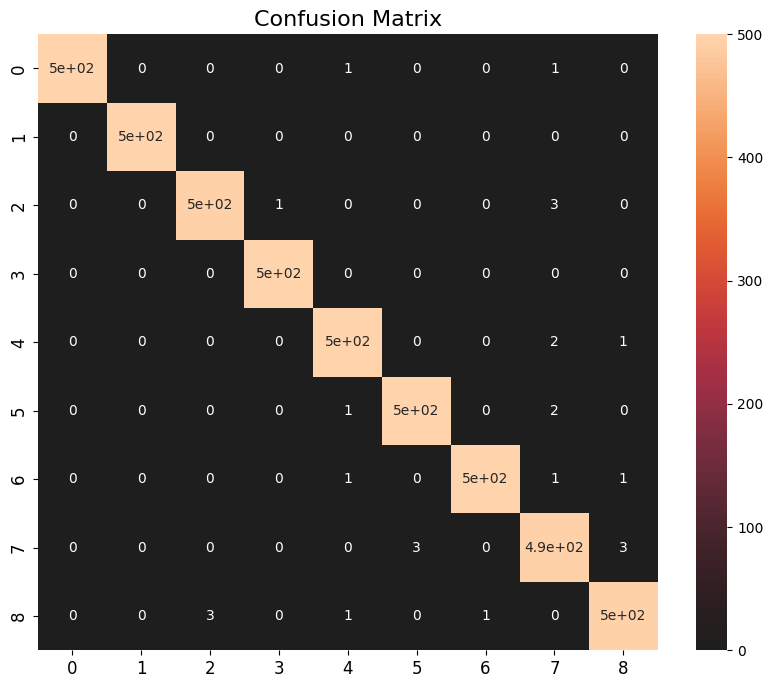

metrics for test:
	 accuracy 0.9942:
	 balanced accuracy 0.9942:


In [176]:
# evaluating model on full test dataset (may take time)
if TEST_ON_LARGE_DATASET:
    pred_2 = model.test_on_dataset(d_test)
    c_matrix(d_test.labels, pred_2)
    Metrics.print_all(d_test.labels, pred_2, 'test')

In [155]:
model.save('accuracy 0.9942 worst 6')

Результат работы пайплайна обучения и тестирования выше тоже будет оцениваться. Поэтому не забудьте присылать на проверку ноутбук с выполнеными ячейками кода с демонстрациями метрик обучения, графиками и т.п. В этом пайплайне Вам необходимо продемонстрировать работу всех реализованных дополнений, улучшений и т.п.

<font color="red">
Настоятельно рекомендуется после получения пайплайна с полными результатами обучения экспортировать ноутбук в pdf (файл -> печать) и прислать этот pdf вместе с самим ноутбуком.
</font>

### Тестирование модели на других наборах данных

Ваша модель должна поддерживать тестирование на других наборах данных. Для удобства, Вам предоставляется набор данных test_tiny, который представляет собой малую часть (2% изображений) набора test. Ниже приведен фрагмент кода, который будет осуществлять тестирование для оценивания Вашей модели на дополнительных тестовых наборах данных.

<font color="red">
Прежде чем отсылать задание на проверку, убедитесь в работоспособности фрагмента кода ниже.
</font>

In [177]:
final_model = Model()
final_model.load('best')
d_test_tiny = Dataset('test_tiny')
pred = final_model.test_on_dataset(d_test_tiny)
Metrics.print_all(d_test_tiny.labels, pred, 'test-tiny')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading...
From (uriginal): https://drive.google.com/uc?id=1-WsnJ0mZD7xaqdQDSC9nyta7whwoJ4Ii
From (redirected): https://drive.google.com/uc?id=1-WsnJ0mZD7xaqdQDSC9nyta7whwoJ4Ii&confirm=t&uuid=c63f5155-d324-45e3-8859-a35a5dcc5bc5
To: /content/best.npz
100%|██████████| 44.8M/44.8M [00:00<00:00, 125MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&confi

Loading dataset test_tiny from npz.
Done. Dataset test_tiny consists of 90 images.


  0%|          | 0/90 [00:00<?, ?it/s]

metrics for test-tiny:
	 accuracy 0.9889:
	 balanced accuracy 0.9889:


Отмонтировать Google Drive.

In [ ]:
drive.flush_and_unmount()

---
# Дополнительные "полезности"

Ниже приведены примеры использования различных функций и библиотек, которые могут быть полезны при выполнении данного практического задания.

### Измерение времени работы кода

Измерять время работы какой-либо функции можно легко и непринужденно при помощи функции timeit из соответствующего модуля:

In [ ]:
import timeit

def factorial(n):
    res = 1
    for i in range(1, n + 1):
        res *= i
    return res


def f():
    return factorial(n=1000)

n_runs = 128
print(f'Function f is caluclated {n_runs} times in {timeit.timeit(f, number=n_runs)}s.')

### Scikit-learn

Для использования "классических" алгоритмов машинного обучения рекомендуется использовать библиотеку scikit-learn (https://scikit-learn.org/stable/). Пример классификации изображений цифр из набора данных MNIST при помощи классификатора SVM:

In [ ]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

# The digits dataset
digits = datasets.load_digits()

# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
_, axes = plt.subplots(2, 4)
images_and_labels = list(zip(digits.images, digits.target))
for ax, (image, label) in zip(axes[0, :], images_and_labels[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001)

# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False)

# We learn the digits on the first half of the digits
classifier.fit(X_train, y_train)

# Now predict the value of the digit on the second half:
predicted = classifier.predict(X_test)

images_and_predictions = list(zip(digits.images[n_samples // 2:], predicted))
for ax, (image, prediction) in zip(axes[1, :], images_and_predictions[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Prediction: %i' % prediction)

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test, predicted)))
disp = metrics.plot_confusion_matrix(classifier, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % disp.confusion_matrix)

plt.show()

### Scikit-image

Реализовывать различные операции для работы с изображениями можно как самостоятельно, работая с массивами numpy, так и используя специализированные библиотеки, например, scikit-image (https://scikit-image.org/). Ниже приведен пример использования Canny edge detector.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature


# Generate noisy image of a square
im = np.zeros((128, 128))
im[32:-32, 32:-32] = 1

im = ndi.rotate(im, 15, mode='constant')
im = ndi.gaussian_filter(im, 4)
im += 0.2 * np.random.random(im.shape)

# Compute the Canny filter for two values of sigma
edges1 = feature.canny(im)
edges2 = feature.canny(im, sigma=3)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title(r'Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()

### Tensorflow 2

Для создания и обучения нейросетевых моделей можно использовать фреймворк глубокого обучения Tensorflow 2. Ниже приведен пример простейшей нейроной сети, использующейся для классификации изображений из набора данных MNIST.

In [ ]:
# Install TensorFlow

import tensorflow as tf

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)

model.evaluate(x_test,  y_test, verbose=2)

<font color="red">
Для эффективной работы с моделями глубокого обучения убедитесь в том, что в текущей среде Google Colab используется аппаратный ускоритель GPU или TPU. Для смены среды выберите "среда выполнения" -> "сменить среду выполнения".
</font>

Большое количество туториалов и примеров с кодом на Tensorflow 2 можно найти на официальном сайте https://www.tensorflow.org/tutorials?hl=ru.

Также, Вам может понадобиться написать собственный генератор данных для Tensorflow 2. Скорее всего он будет достаточно простым, и его легко можно будет реализовать, используя официальную документацию TensorFlow 2. Но, на всякий случай (если не удлось сразу разобраться или хочется вникнуть в тему более глубоко), можете посмотреть следующий отличный туториал: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.

### Numba

В некоторых ситуациях, при ручных реализациях графовых алгоритмов, выполнение многократных вложенных циклов for в python можно существенно ускорить, используя JIT-компилятор Numba (https://numba.pydata.org/).
Примеры использования Numba в Google Colab можно найти тут:
1. https://colab.research.google.com/github/cbernet/maldives/blob/master/numba/numba_cuda.ipynb
2. https://colab.research.google.com/github/evaneschneider/parallel-programming/blob/master/COMPASS_gpu_intro.ipynb

> Пожалуйста, если Вы решили использовать Numba для решения этого практического задания, еще раз подумайте, нужно ли это Вам, и есть ли возможность реализовать требуемую функциональность иным способом. Используйте Numba только при реальной необходимости.



### Работа с zip архивами в Google Drive

Запаковка и распаковка zip архивов может пригодиться при сохранении и загрузки Вашей модели. Ниже приведен фрагмент кода, иллюстрирующий помещение нескольких файлов в zip архив с последующим чтением файлов из него. Все действия с директориями, файлами и архивами должны осущетвляться с примонтированным Google Drive.


Создадим 2 изображения, поместим их в директорию tmp внутри PROJECT_DIR, запакуем директорию tmp в архив tmp.zip.

In [ ]:
PROJECT_DIR = "/dev/prak_nn_1/"
arr1 = np.random.rand(100, 100, 3) * 255
arr2 = np.random.rand(100, 100, 3) * 255

img1 = Image.fromarray(arr1.astype('uint8'))
img2 = Image.fromarray(arr2.astype('uint8'))

p = "/content/drive/MyDrive/" + PROJECT_DIR

if not (Path(p) / 'tmp').exists():
    (Path(p) / 'tmp').mkdir()

img1.save(str(Path(p) / 'tmp' / 'img1.png'))
img2.save(str(Path(p) / 'tmp' / 'img2.png'))

%cd $p
!zip -r "tmp.zip" "tmp"

Распакуем архив tmp.zip в директорию tmp2 в PROJECT_DIR. Теперь внутри директории tmp2 содержится директория tmp, внутри которой находятся 2 изображения.

In [ ]:
p = "/content/drive/MyDrive/" + PROJECT_DIR
%cd $p
!unzip -uq "tmp.zip" -d "tmp2"